In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.optimize import minimize
from scipy.spatial.distance import pdist, squareform

from qubovert.problems import GraphPartitioning
from qubovert.utils import solve_qubo_bruteforce as qubo_solver


import pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import DigitalAnalogDevice, MockDevice  
from pulser.waveforms import InterpolatedWaveform, BlackmanWaveform

import sys
sys.path.append('..')

from source.qubo import solve_qubo_bruteforce, plot_distribution, anneal, draw_solutions, evaluate_mapping, get_Q_from_coords, get_register_embedding
from source.qubovert_custom import problem_to_qubo_matrix

In [2]:
edges = {
    ("a", "b"),
    ("a", "c"),
    ("b", "c"),
    ("d", "e"),
    ("f", "e"),
    ("d", "f"),
    ("a", "f"),
    ("b", "e"),
    }
problem = GraphPartitioning(edges) 
Q = problem.to_qubo()

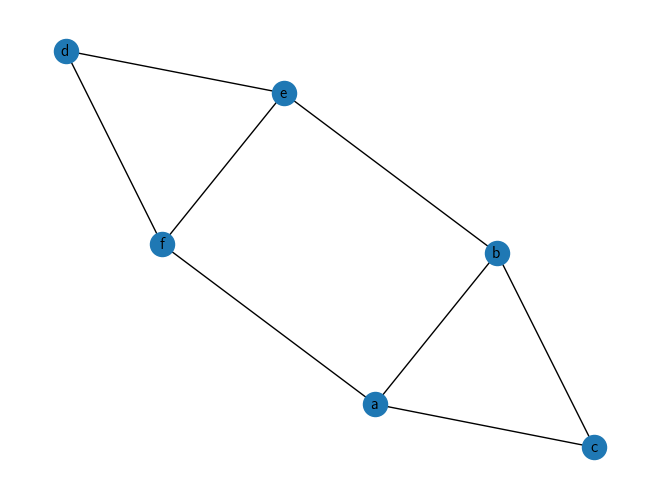

In [3]:
# draw the graph
G = nx.Graph()
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
plt.show()

In [4]:
Q = problem_to_qubo_matrix(problem)
solutions = solve_qubo_bruteforce(Q, n=3)
solutions

[(array([0, 0, 0, 0, 1, 1]), -17.0),
 (array([0, 0, 0, 1, 0, 1]), -17.0),
 (array([0, 1, 1, 0, 0, 0]), -17.0)]

/home/bigbogo/Documents/Projects/PulserLearn/dev/../source/qubo.py:67: UserWarning: The diagonal elements of the QUBO matrix are not equal.
  warnings.warn("The diagonal elements of the QUBO matrix are not equal.")
/home/bigbogo/Documents/Projects/PulserLearn/dev/../source/qubo.py:68: UserWarning: Diagonal elements: [-1.5   -1.625 -1.5   -1.5   -1.5   -1.625]
  warnings.warn(f"Diagonal elements: {np.diag(Q)}")
/home/bigbogo/Documents/Projects/PulserLearn/dev/../source/qubo.py:91: UserWarning: Relative differences between the QUBO matrix and the new matrix are too high: 1.9996992817699797
  warnings.warn(f"Relative differences between the QUBO matrix and the new matrix are too high: {np.max(rel_diff)}")
/home/bigbogo/Documents/Projects/PulserLearn/dev/../source/qubo.py:92: UserWarning: rel_diff: 
[[0.00000000e+00 1.99519797e+00 1.99881528e+00 1.99073012e+00
  1.99969928e+00 1.99950165e+00]
 [1.99519797e+00 0.00000000e+00 3.95661395e-03 1.98760258e+00
  1.96179867e+00 1.98369487e+00]
 [1

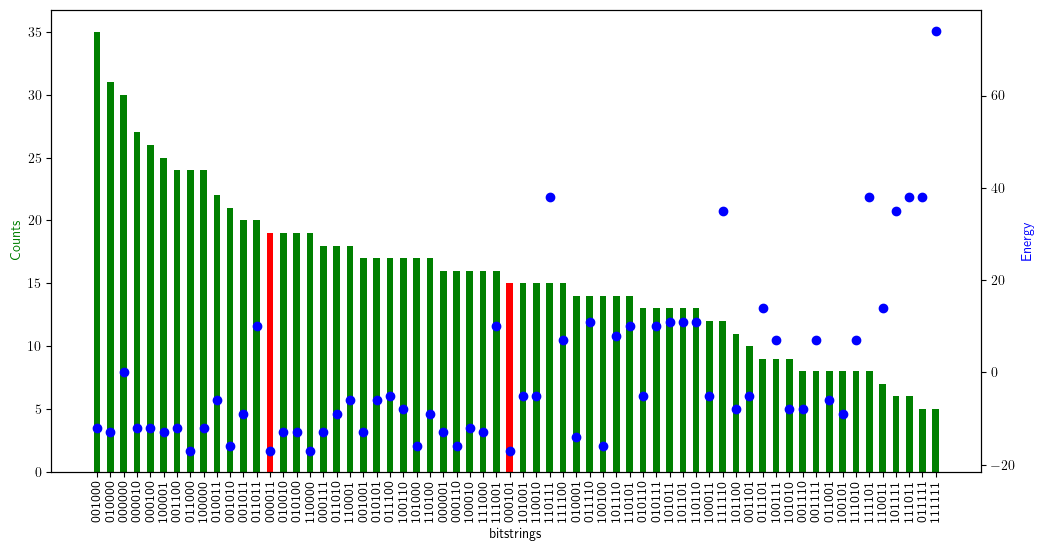

In [5]:
# divide Q by 8 to not have atoms touch (in Rydberg blockade)
# does not change the solution
coords, res = get_register_embedding(Q/8, seed=1, lossf="mae", device=DigitalAnalogDevice)
qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

reg = Register(qubits)
Omega = 0.5
delta_i = -2.0  # just has to be negative
delta_f = -delta_i  # just has to be positive
T = 5_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
count_dict = anneal(reg, Omega, delta_i, delta_f, T)

# plotting
solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
res_states = np.array([[int(s) for s in state[0]] for state in res_states])
res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
plot_distribution(count_dict, solutions_strs, show=False)
plt.ylabel("Counts", color="green")
plt.twinx()
plt.ylabel("Energy", color="blue")
plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")

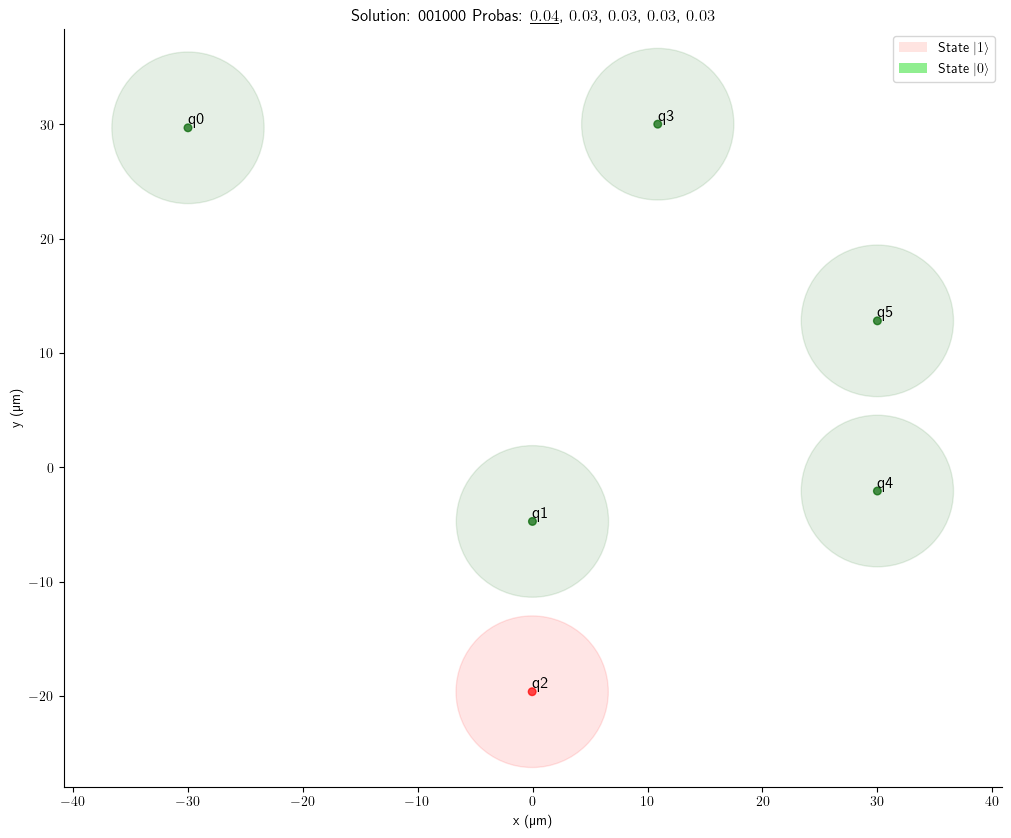

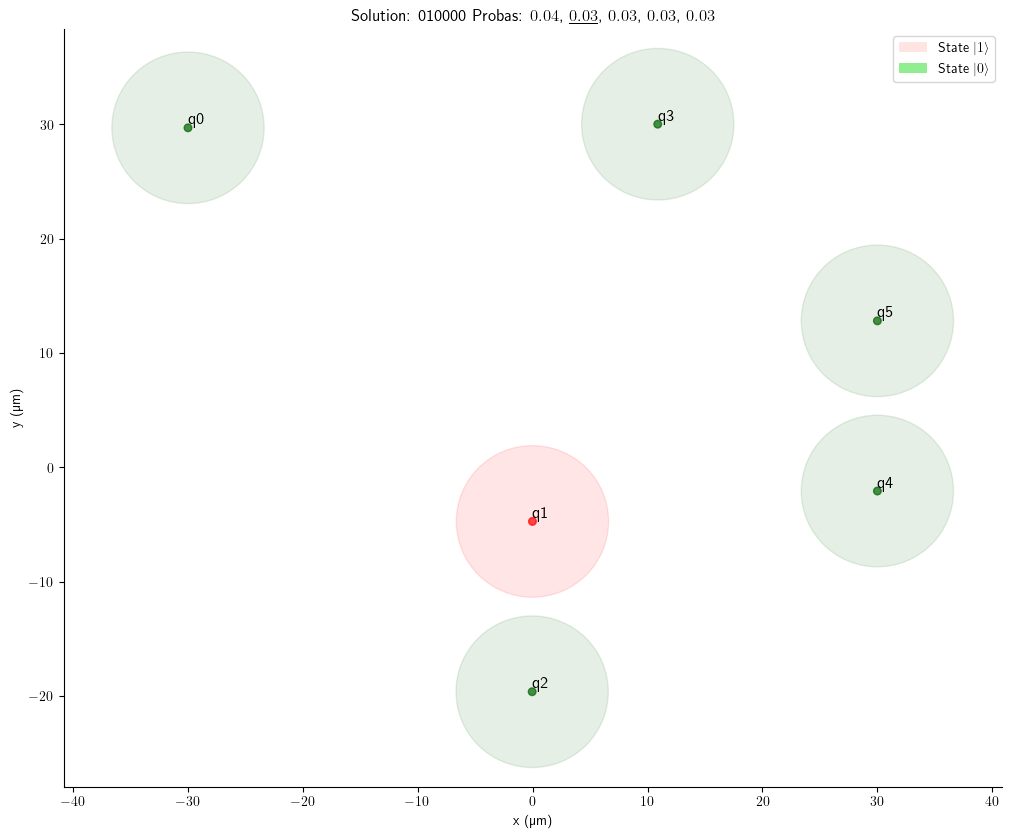

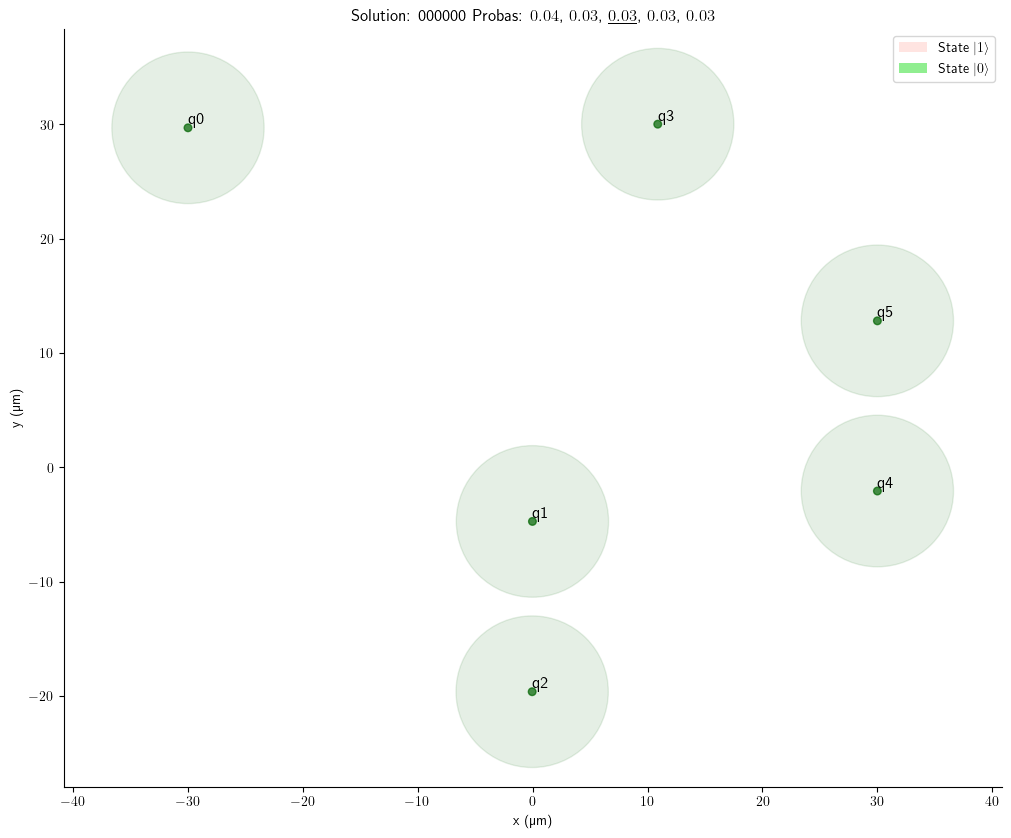

In [6]:
draw_solutions(reg, count_dict, n=3, device=MockDevice, draw_graph=True)

# More graphs

In [7]:
from networkx import gnm_random_graph

------------- graph  0 -------------


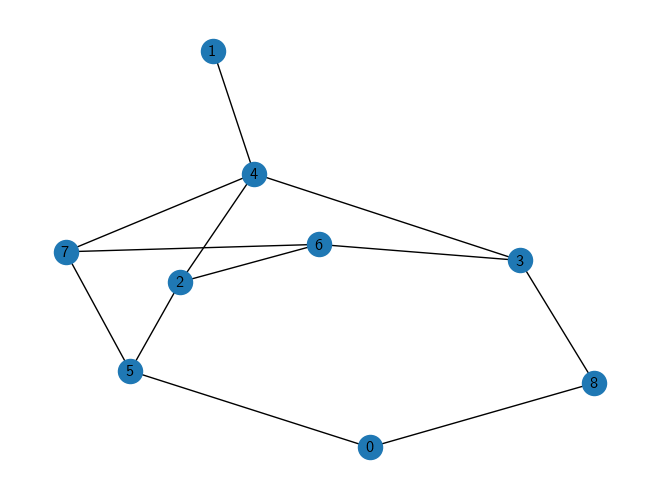

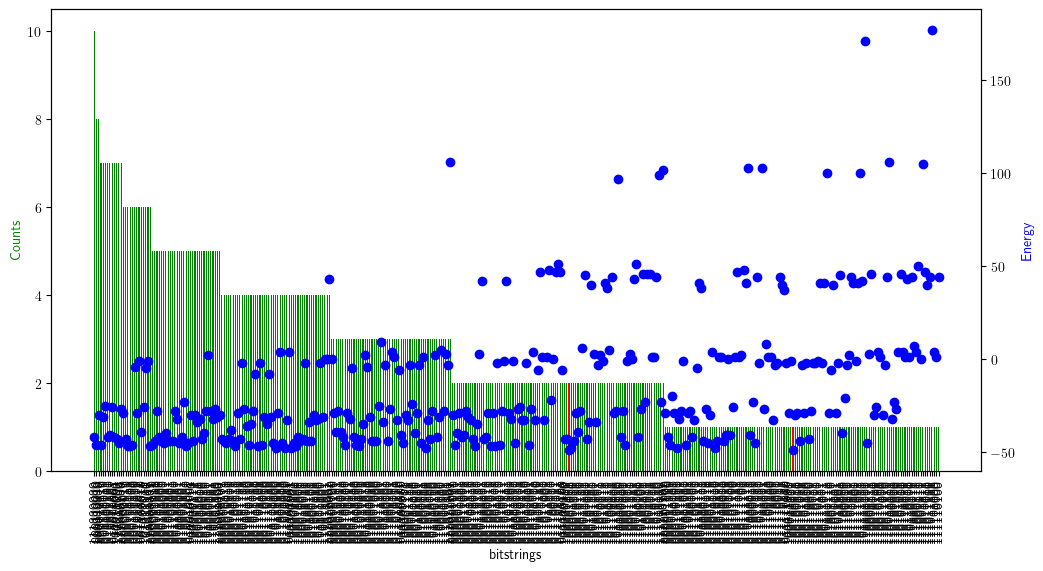

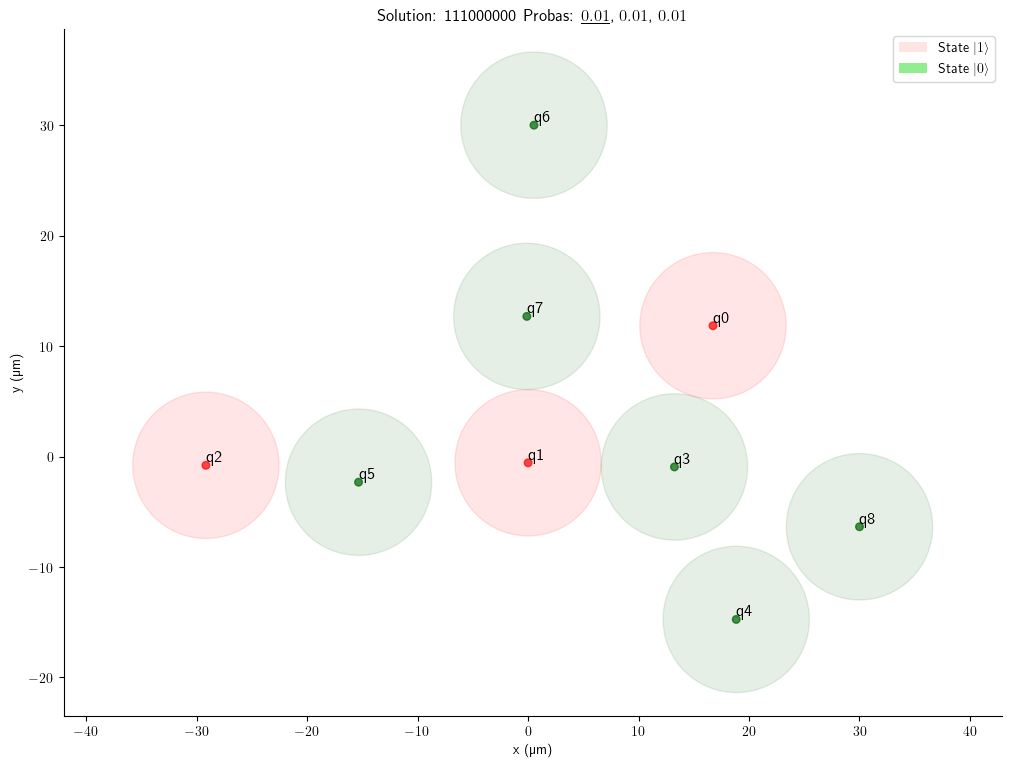

------------- graph  1 -------------


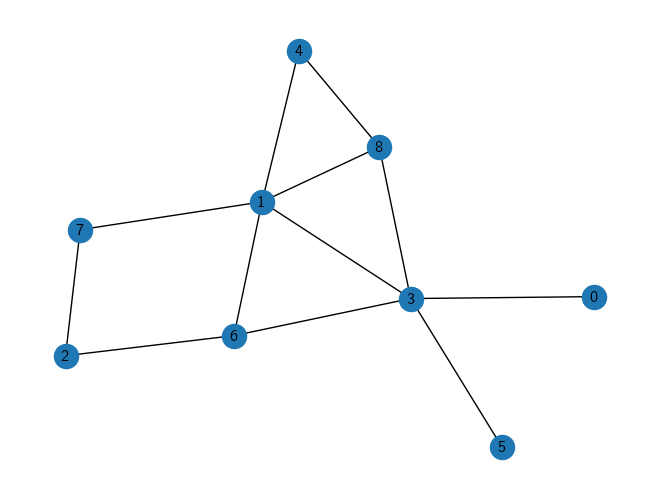

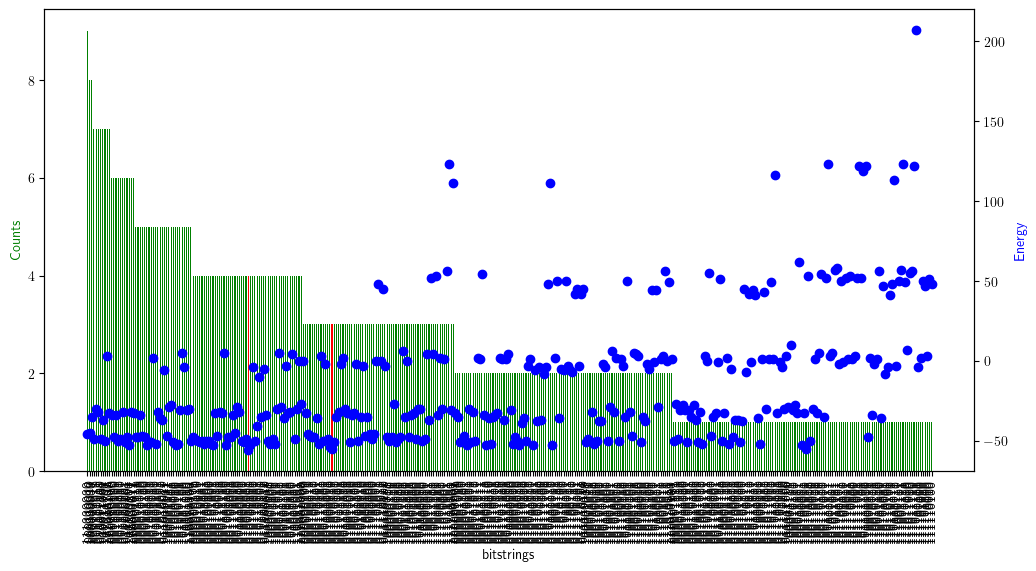

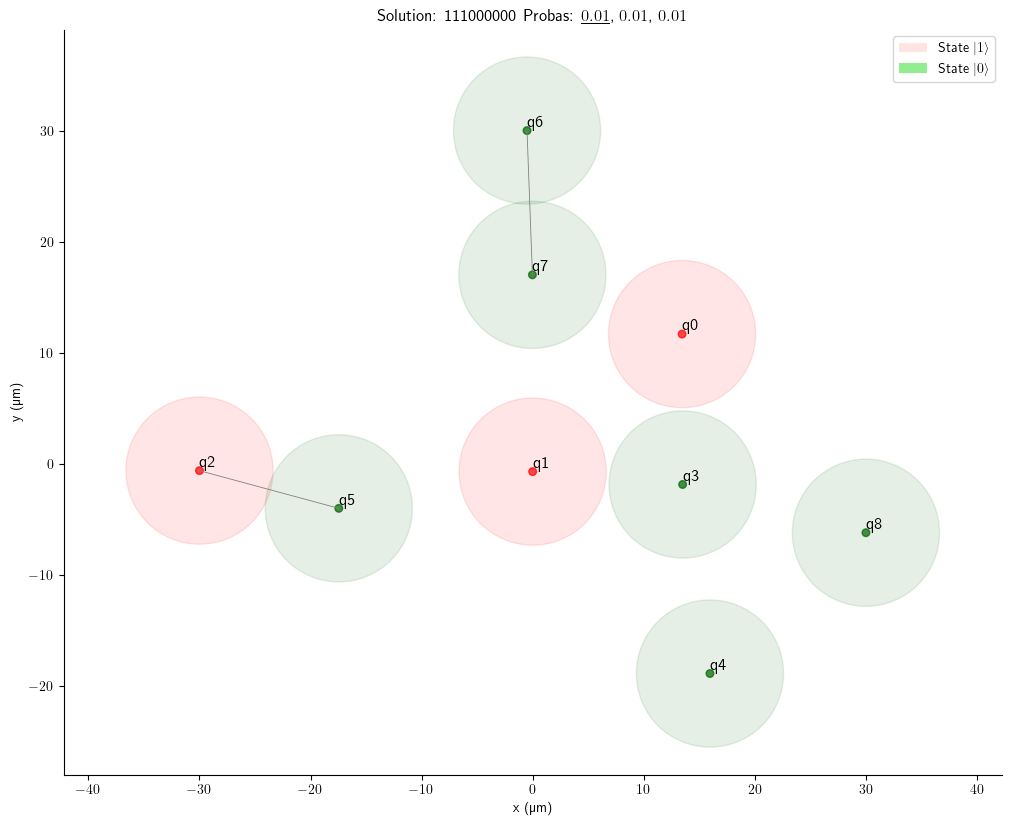

------------- graph  2 -------------


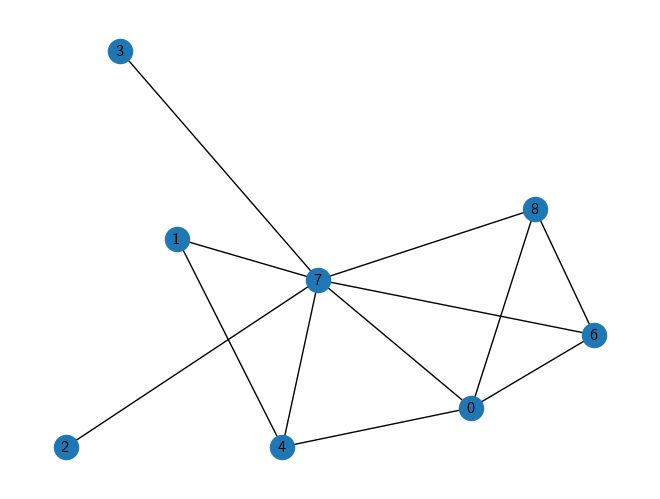

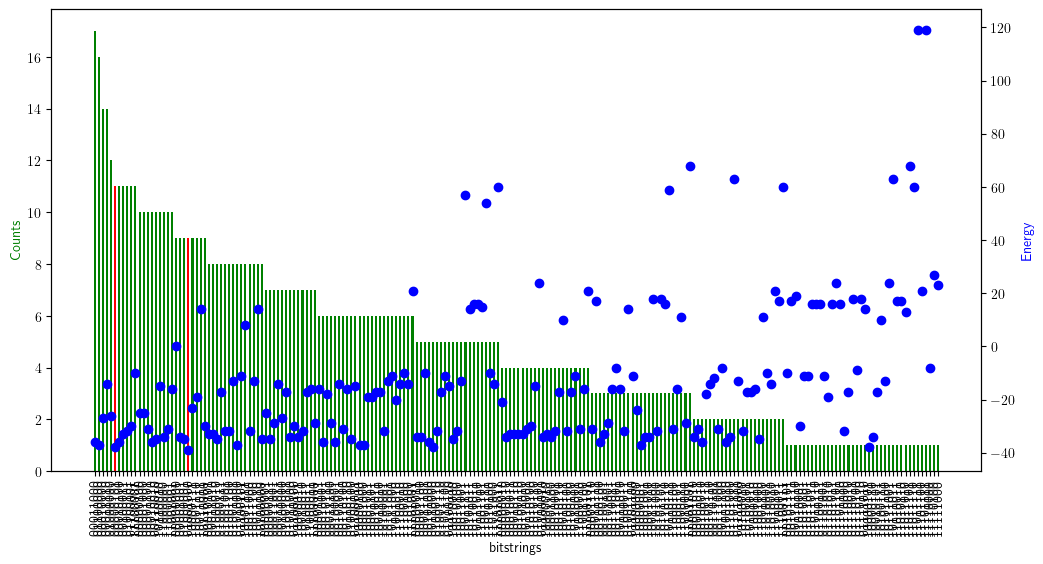

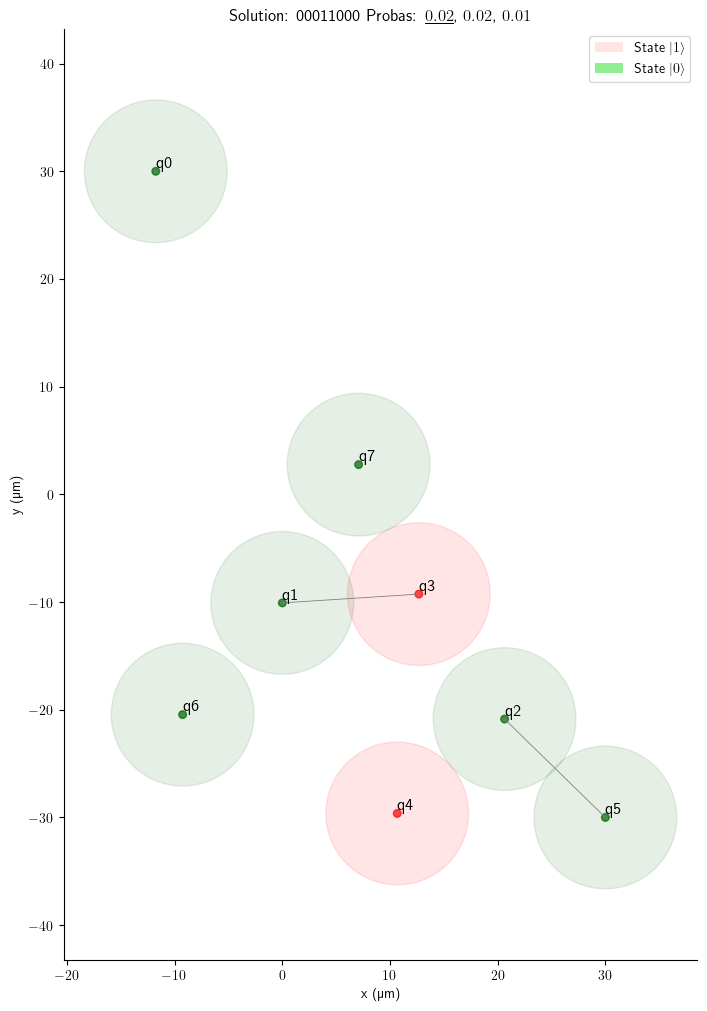

------------- graph  3 -------------


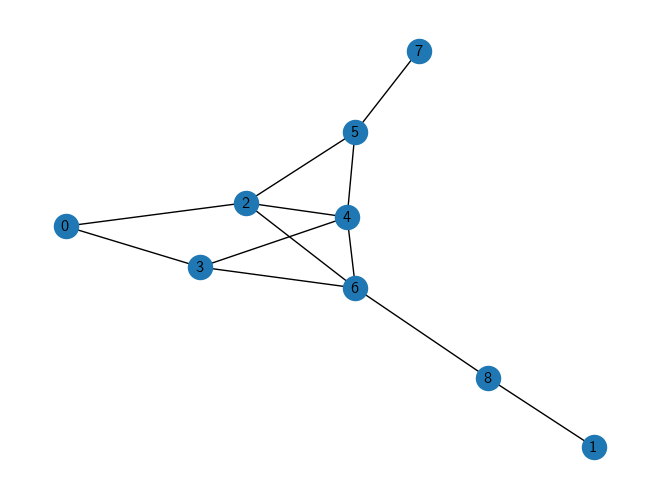

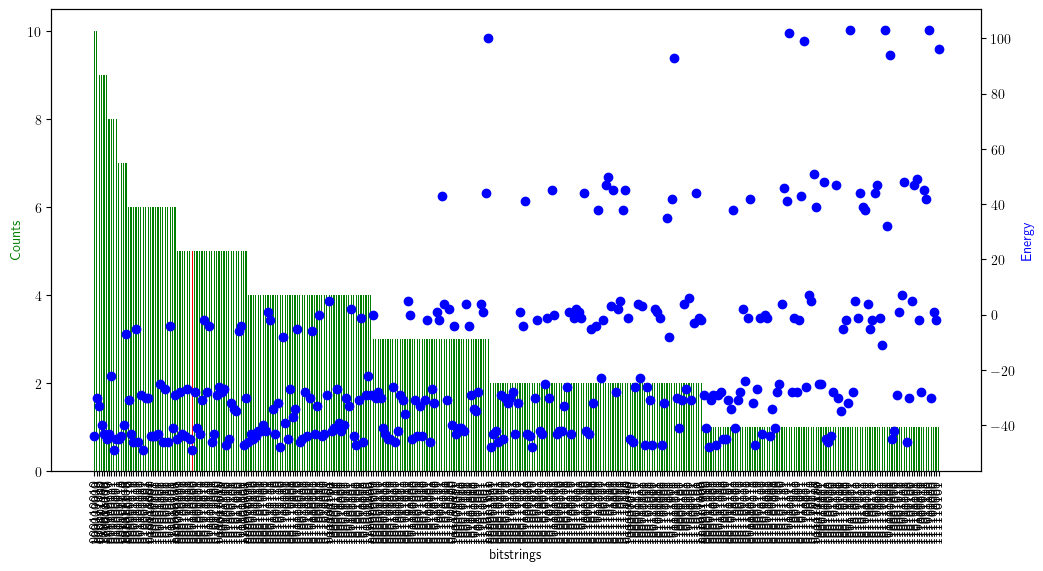

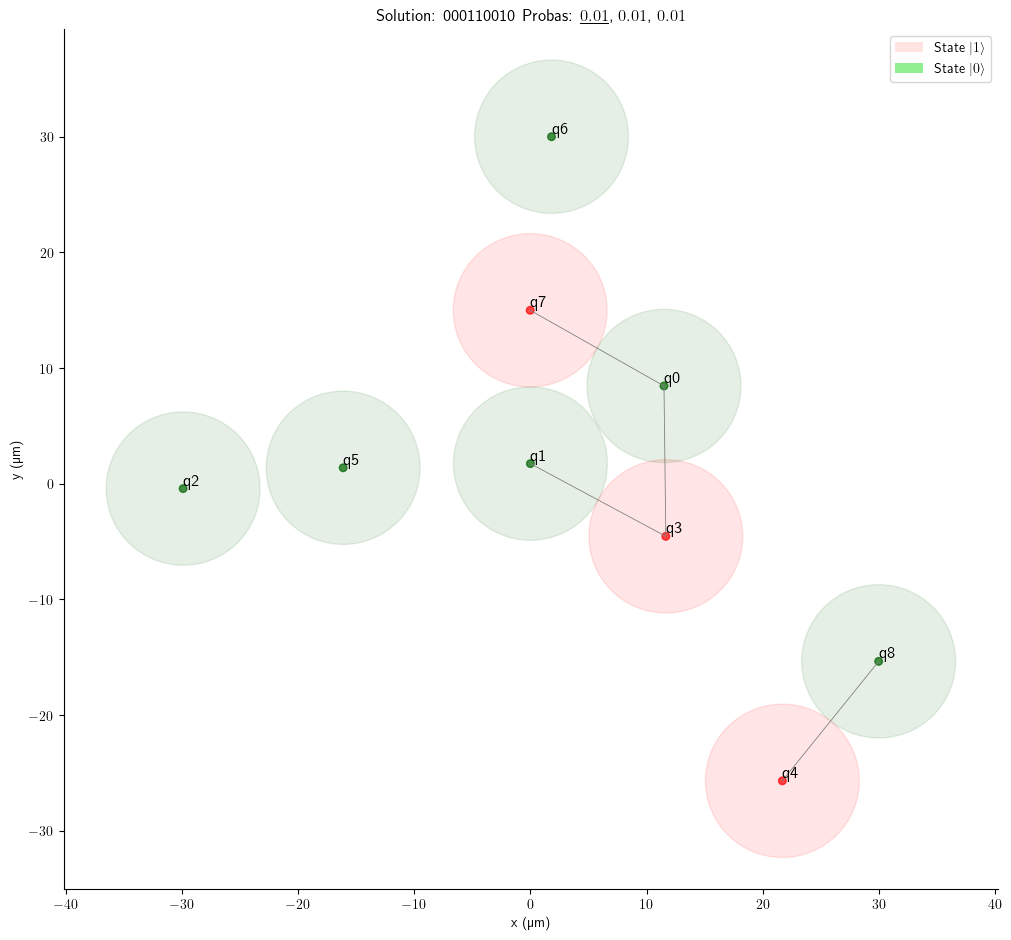

------------- graph  4 -------------


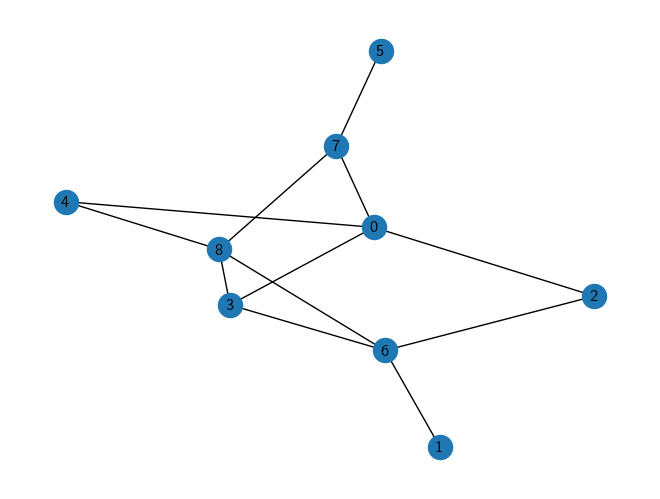

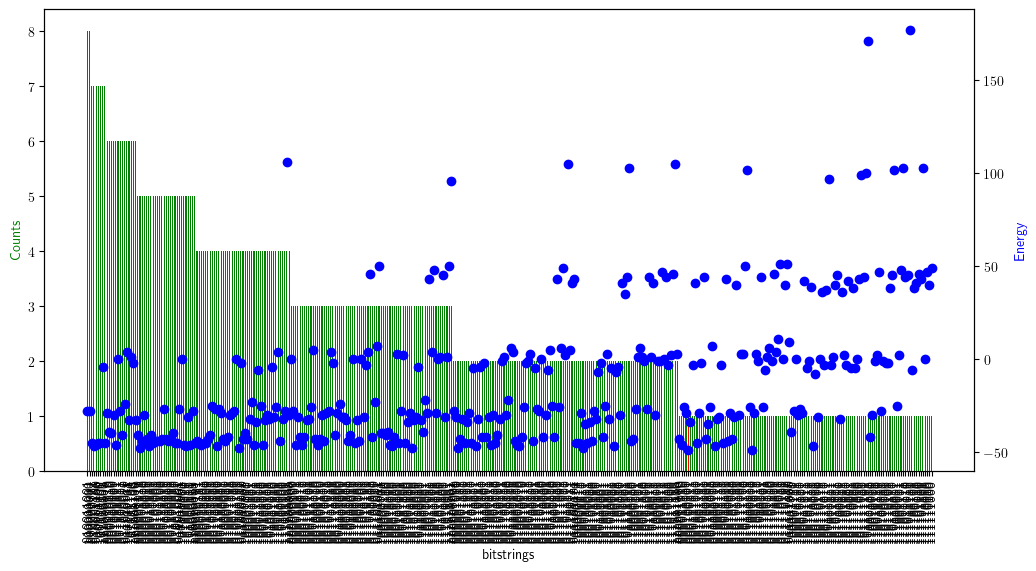

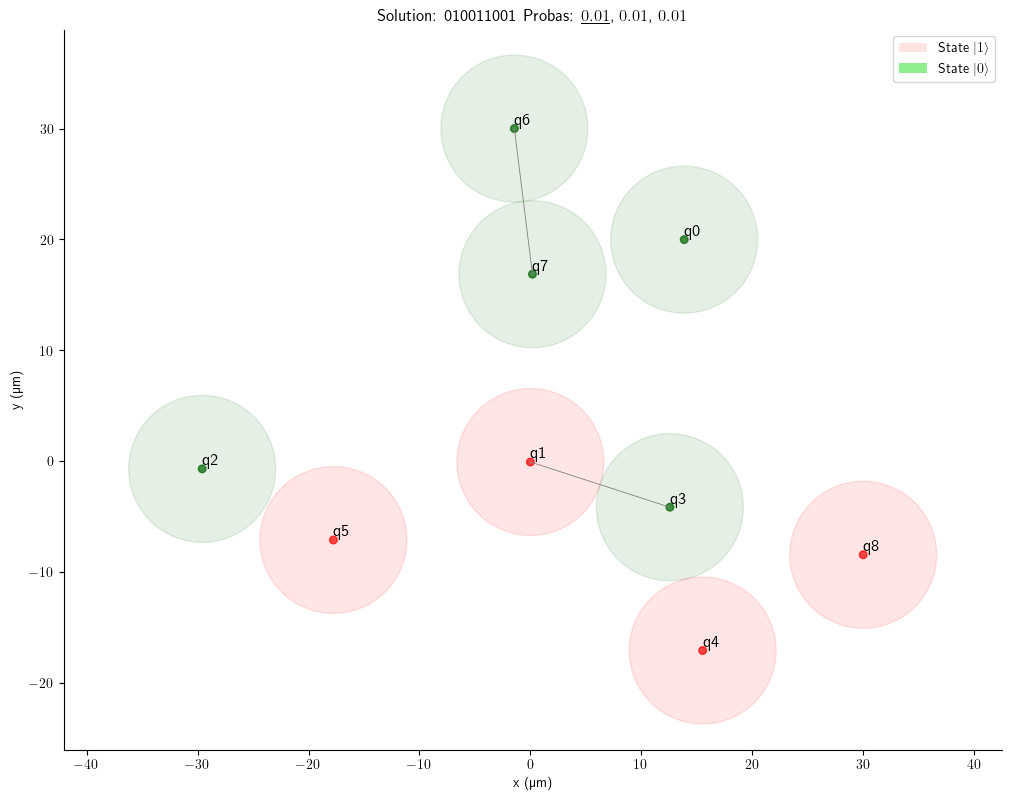

In [8]:
random_state = np.random.RandomState(42)
for nn in range(5):
    print("------------- graph ", nn, "-------------")
    g = gnm_random_graph(9, 12, seed=random_state) # n, m: number of nodes, number of edges
    edges = set(g.edges) 
    G = nx.Graph()
    G.add_edges_from(edges)
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold')
    plt.show()

    problem = GraphPartitioning(edges) 
    Q = problem.to_qubo()

    Q = problem_to_qubo_matrix(problem)
    solutions = solve_qubo_bruteforce(Q, n=3)

    # divide Q by 8 to not have atoms touch (in Rydberg blockade)
    # does not change the solution
    coords, res = get_register_embedding(Q/8, seed=1, lossf="mae", device=DigitalAnalogDevice, ignore_warnings=True)
    qubits = {f"q{i}": coord for (i, coord) in enumerate(coords)}

    reg = Register(qubits)
    Omega = 0.5
    delta_i = -2.0  # just has to be negative
    delta_f = -delta_i  # just has to be positive
    T = 5_000  # time in ns, we choose a time long enough to ensure the propagation of information in the system
    count_dict = anneal(reg, Omega, delta_i, delta_f, T)

    # plotting
    solutions_strs = [''.join(map(str, s[0])) for s in solutions[0:2]]
    res_states = sorted(list(count_dict.items()), key=lambda x: x[1], reverse=True) 
    res_states = np.array([[int(s) for s in state[0]] for state in res_states])
    res_vals = np.einsum("ij,jk,ik->i", res_states, Q, res_states)
    plot_distribution(count_dict, solutions_strs, show=False)
    plt.ylabel("Counts", color="green")
    plt.twinx()
    plt.ylabel("Energy", color="blue")
    plt.scatter(np.arange(len(res_vals)), res_vals, c="blue")
    plt.show()
    draw_solutions(reg, count_dict, n=1, device=MockDevice, draw_graph=True)